In [1]:
import pandas as pd
import numpy as np
from nltk.stem.porter import *
import nltk
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Corona_NLP_train.csv',encoding = 'latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
df.shape

(41157, 6)

In [4]:
df['Location'].value_counts()

Location
London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: count, Length: 12220, dtype: int64

In [5]:
df.loc[df['Sentiment']=='Extremely Positive', 'OriginalTweet'][12]

'#horningsea is a caring community. LetÂ\x92s ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. https://t.co/lsGrXXhjhh'

In [6]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')


In [7]:
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    

In [8]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

new_df = df[['Tweet','Sentiment']]
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\engla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                                       []
1        [v, c, e,  , T, l, k,  , u, r,  , n, e, g, h, ...
2        [C, r, n, v, r, u,  , A, u, r, l, :,  , W, l, ...
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e, ...
4        [M, e, ,,  , r, e,  , u, p, e, r, r, k, e,  , ...
                               ...                        
41152    [A, r, l, n, e,  , p, l,  , f, f, e, r, n, g, ...
41153    [R, e, p, n, e,  , c, p, l, n,  , n,  , p, r, ...
41154    [Y, u,  , k, n, w,  , Â, ,  , g, e, n, g,  , ...
41155    [w, r, n, g,  , h,  , h, e,  , e, l, l,  , h, ...
41156    [W, e, l, l,  , n, e, w, /, u, e,  , R, f,  , ...
Name: Tweet, Length: 41157, dtype: object

In [9]:
binary_dataset = new_df.copy()
binary_dataset["Sentiment"] = binary_dataset["Sentiment"].replace('Positive',1) 
binary_dataset["Sentiment"] = binary_dataset["Sentiment"].replace('Extremely Positive',1) 
binary_dataset["Sentiment"] = binary_dataset["Sentiment"].replace('Neutral',1) 
binary_dataset["Sentiment"] = binary_dataset["Sentiment"].replace('Negative',0) 
binary_dataset["Sentiment"] = binary_dataset["Sentiment"].replace('Extremely Negative',0) 

In [10]:
binary_dataset.head()

,Tweet,Sentiment
0,,1
1,advice Talk your neighbours family exchange ph...,1
2,Coronavirus Australia: Woolworths give elderly...,1
3,food stock not the only one which empty... PLE...,1
4,"Me, ready supermarket during the #COVID19 outb...",0


In [11]:
binary_dataset.shape

(41157, 2)

In [12]:
binary_dataset.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [13]:
binary_dataset.Sentiment.value_counts()

Sentiment
1    25759
0    15398
Name: count, dtype: int64

In [14]:
binary_dataset

,Tweet,Sentiment
0,,1
1,advice Talk your neighbours family exchange ph...,1
2,Coronavirus Australia: Woolworths give elderly...,1
3,food stock not the only one which empty... PLE...,1
4,"Me, ready supermarket during the #COVID19 outb...",0
...,...,...
41152,Airline pilots offering stock supermarket shel...,1
41153,Response complaint not provided citing COVID-1...,0
41154,You know itÂs getting tough when rationing to...,1
41155,wrong that the smell hand sanitizer starting t...,1


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(binary_dataset.Tweet, binary_dataset.Sentiment,test_size = 0.2,random_state=0,stratify = binary_dataset.Sentiment.values) 
print("train shape : ", X_train.shape)
print("valid shape : ", X_valid.shape)

train shape :  (32925,)
valid shape :  (8232,)


## Using CountVectorizer, No SMOTE

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 39740)
X_train.shape :  (8232, 39740)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy)
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9634927866362946
Validation accuracy Score :  0.8630952380952381
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      2761
           1       0.92      0.87      0.89      5471

    accuracy                           0.86      8232
   macro avg       0.84      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232



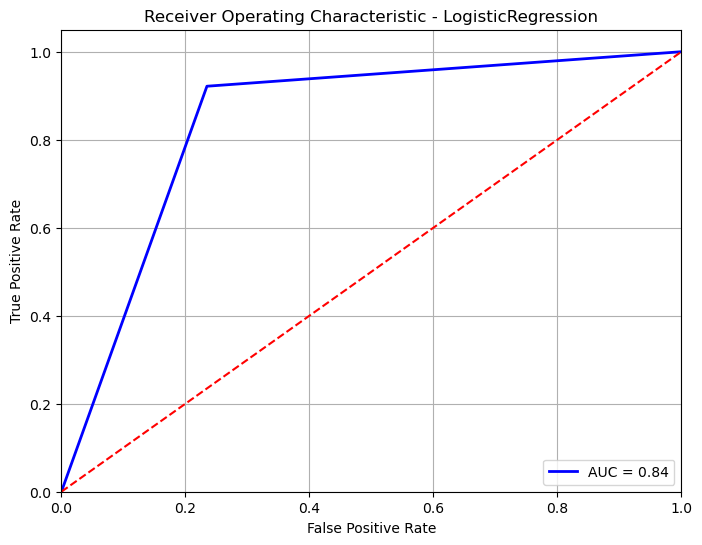

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and sgd_prediction are already defined
fpr, tpr, threshold = roc_curve(y_valid, logreg_prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LogisticRegression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [22]:
from sklearn.linear_model import SGDClassifier
params = {'random_state': 39, 'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'l1'}

sgd_clf = SGDClassifier(**params)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train) *100)
print("Validation accuracy Score : ",sgd_accuracy *100 )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  90.79726651480638
Validation accuracy Score :  87.9980563654033
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      2820
           1       0.93      0.88      0.91      5412

    accuracy                           0.88      8232
   macro avg       0.86      0.88      0.87      8232
weighted avg       0.88      0.88      0.88      8232



In [20]:
y_true = y_valid # This should be the variable containing your true labels
y_pred = sgd_prediction  # This should be the variable containing your model's predictions

# Calculate metrics
from sklearn.metrics import recall_score , precision_score , f1_score

recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Recall: {recall * 100:.3f}%")
print(f"Precision: {precision * 100:.3f}%")
print(f"F1-Score: {f1 * 100:.3f}%")

# Generate a full classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Recall: 87.998%
Precision: 87.955%
F1-Score: 87.881%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3080
           1       0.88      0.93      0.91      5152

    accuracy                           0.88      8232
   macro avg       0.88      0.86      0.87      8232
weighted avg       0.88      0.88      0.88      8232



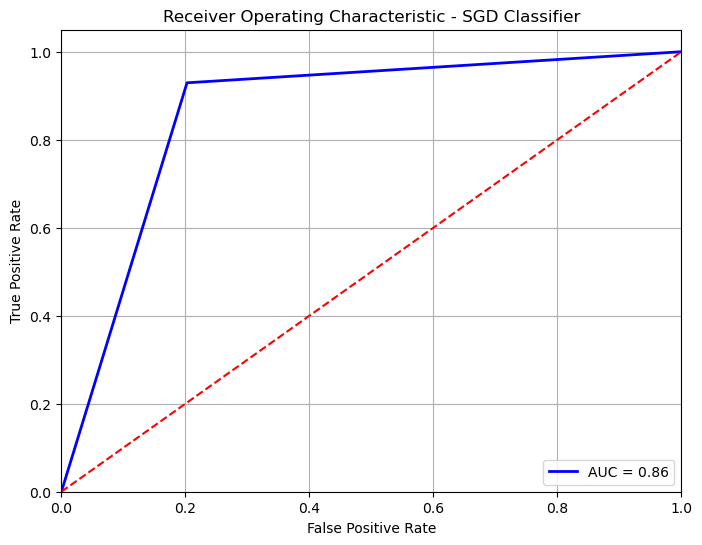

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and sgd_prediction are already defined
fpr, tpr, threshold = roc_curve(y_valid, sgd_prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SGD Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svc_clf = SVC(**{'C': 1, 'gamma': 'scale'}, random_state=0)


svc_clf.fit(X_train, y_train)

svc_prediction = svc_clf.predict(X_valid)
svc_accuracy = accuracy_score(y_valid, svc_prediction)

print("Training accuracy Score    : ", svc_clf.score(X_train, y_train))
print("Validation accuracy Score : ", svc_accuracy)

print(classification_report(y_valid, svc_prediction))


Training accuracy Score    :  0.961002277904328
Validation accuracy Score :  0.8330903790087464
              precision    recall  f1-score   support

           0       0.86      0.66      0.75      3080
           1       0.82      0.94      0.88      5152

    accuracy                           0.83      8232
   macro avg       0.84      0.80      0.81      8232
weighted avg       0.84      0.83      0.83      8232



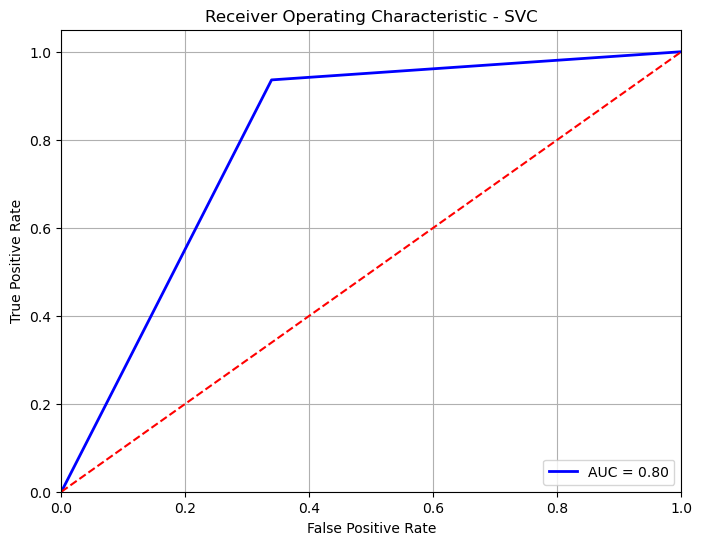

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and sgd_prediction are already defined
fpr, tpr, threshold = roc_curve(y_valid, svc_prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


[[2456  364]
 [ 624 4788]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

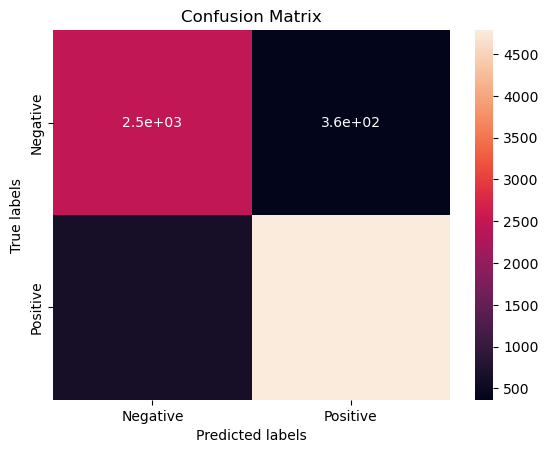

In [26]:
labels = ['Negative', 'Positive']
cm = confusion_matrix(sgd_prediction, y_valid)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

[[2357  404]
 [ 723 4748]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

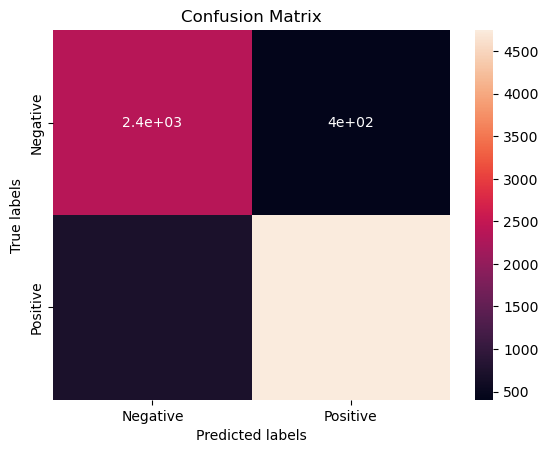

In [27]:
labels = ['Negative', 'Positive']
cm = confusion_matrix(logreg_prediction, y_valid)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## SMOTE, Using TF-IDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
import numpy as np

tfidf_vectorizer = TfidfVectorizer()
smote = SMOTE(random_state=0)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('smote', smote)
])
X_train, X_valid, y_train, y_valid = train_test_split(binary_dataset.Tweet, binary_dataset.Sentiment,test_size = 0.2,random_state=0,stratify = binary_dataset.Sentiment.values) 

X_train_vect, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print("Transformed feature matrix shape:", X_train_vect.shape)
print("Transformed label vector shape:", y_train_resampled.shape)

X_valid_vect = tfidf_vectorizer.transform(X_valid)


Transformed feature matrix shape: (41214, 39882)
Transformed label vector shape: (41214,)


In [30]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train_vect, y_train_resampled)

logreg_prediction = logreg.predict(X_valid_vect)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train_vect,y_train_resampled))
print("Validation accuracy Score : ",logreg_accuracy)
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.8990391614499927
Validation accuracy Score :  0.8192419825072886
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      3146
           1       0.85      0.86      0.85      5086

    accuracy                           0.82      8232
   macro avg       0.81      0.81      0.81      8232
weighted avg       0.82      0.82      0.82      8232



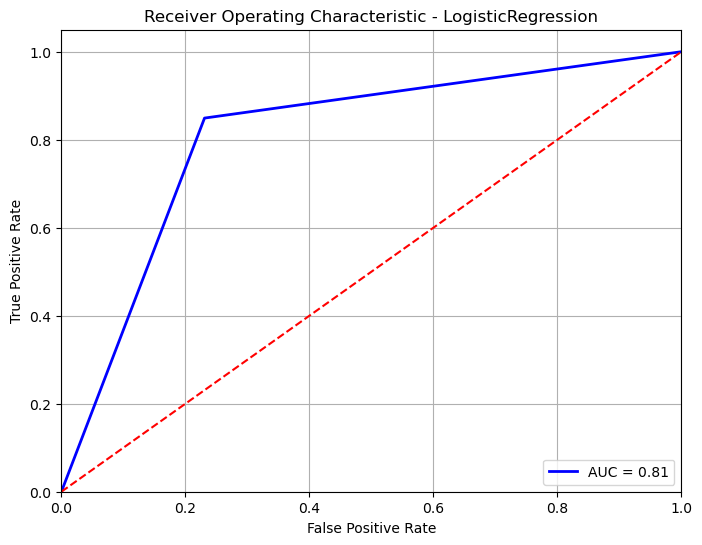

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr, tpr, threshold = roc_curve(y_valid, logreg_prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LogisticRegression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [32]:
from sklearn.linear_model import SGDClassifier
params = {'random_state': 39, 'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'l1'}

sgd_clf = SGDClassifier()

sgd_clf.fit(X_train_vect,y_train_resampled)

sgd_prediction = sgd_clf.predict(X_valid_vect)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train_vect,y_train_resampled))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.8757461056922405
Validation accuracy Score :  0.8079446064139941
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      3131
           1       0.84      0.85      0.85      5101

    accuracy                           0.81      8232
   macro avg       0.80      0.79      0.80      8232
weighted avg       0.81      0.81      0.81      8232



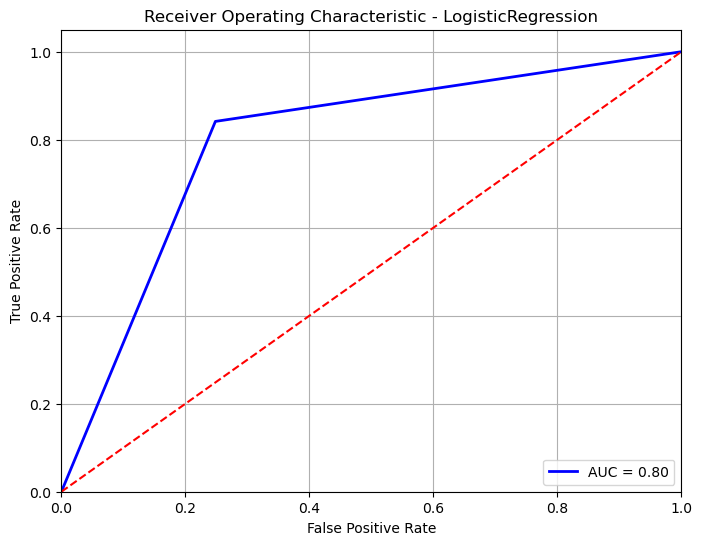

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and sgd_prediction are already defined
fpr, tpr, threshold = roc_curve(y_valid, sgd_prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SGDClassifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svc_clf = SVC(random_state=0)


svc_clf.fit(X_train_vect, y_train_resampled)

svc_prediction = svc_clf.predict(X_valid_vect)
svc_accuracy = accuracy_score(y_valid, svc_prediction)

print("Training accuracy Score    : ", svc_clf.score(X_train_vect, y_train_resampled))
print("Validation accuracy Score : ", svc_accuracy)

print(classification_report(y_valid, svc_prediction))


Training accuracy Score    :  0.991823166885039
Validation accuracy Score :  0.8432944606413995
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      3080
           1       0.84      0.93      0.88      5152

    accuracy                           0.84      8232
   macro avg       0.85      0.81      0.82      8232
weighted avg       0.85      0.84      0.84      8232



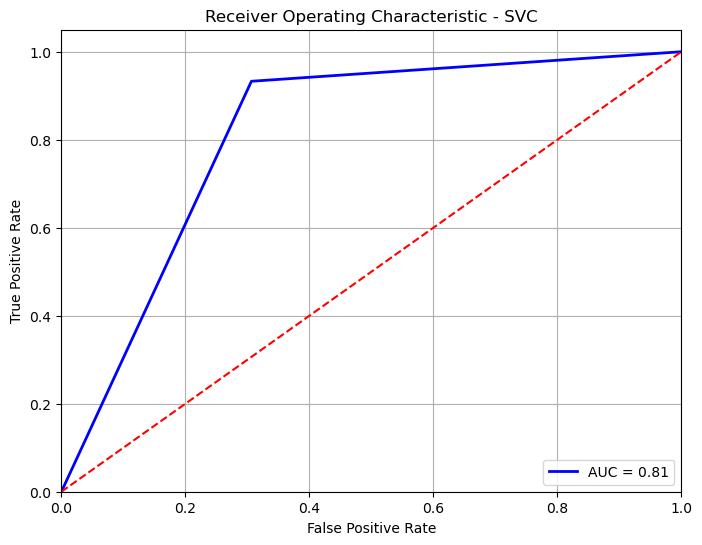

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(y_valid, svc_prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()